# Imports

In [1]:
import os, gc
import torch
from datetime import datetime

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
pd.set_option('display.max_columns', None)

# Initial setup

## GPU

In [2]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cuda


## Pytorch lightning and forecasting

In [3]:
from pytorch_forecasting import TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer, MultiNormalizer

# Load input

In [4]:
import json
import sys
sys.path.append( '..' )
from Class.Parameters import Parameters
from script.utils import *
from dataclasses import dataclass

@dataclass
class args:
    result_folder = '../results/age_subgroup/AGE019/' 
    figPath = os.path.join(result_folder, 'figures_morris')
    checkpoint_folder = os.path.join(result_folder, 'checkpoints')
    input_filePath = '../2022_May_age_groups_old/Top_100.csv'

    configPath = '../configurations/age_groups_old.json'
    model_path = get_best_model_path(checkpoint_folder)

    # set this to false when submitting batch script, otherwise it prints a lot of lines
    show_progress_bar = True

if not os.path.exists(args.figPath):
    os.makedirs(args.figPath, exist_ok=True)

Checkpoint model best-epoch=0.ckpt.


In [5]:
start = datetime.now()
print(f'Started at {start}')

total_data = pd.read_csv(args.input_filePath)
print(total_data.shape)
total_data.head()

Started at 2023-03-20 23:32:31.602144
(80900, 13)


,FIPS,Date,VaccinationFull,AGE019,AGE2029,AGE3039,AGE4049,AGE5064,AGE6579,AGE80PLUS,Cases,TimeFromStart,SinWeekly
0,2261,2020-12-13,0.0,0.2084,0.1114,0.1927,0.1230,0.2485,0.0849,0.0311,2.0,288,-0.7818
1,4013,2020-12-13,0.0,0.2123,0.1402,0.1894,0.1524,0.1766,0.0748,0.0543,3367.0,288,-0.7818
2,4019,2020-12-13,0.0,0.2007,0.1627,0.1468,0.1215,0.1809,0.1107,0.0767,795.0,288,-0.7818
3,6001,2020-12-13,0.0,0.1730,0.1243,0.2463,0.1703,0.1763,0.0616,0.0482,563.0,288,-0.7818
4,6013,2020-12-13,0.0,0.1980,0.1149,0.1720,0.1709,0.2099,0.0778,0.0565,429.0,288,-0.7818


# Model

In [6]:
tft = TemporalFusionTransformer.load_from_checkpoint(args.model_path)

print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

Number of parameters in network: 16.5k


# Config

In [7]:
import json
import sys
sys.path.append( '..' )
from Class.Parameters import Parameters
from script.utils import *

with open(args.configPath, 'r') as input_file:
  config = json.load(input_file)

parameters = Parameters(config, **config)

In [9]:
# this is only because the subgroups were trained using individual static features
parameters.data.static_features = tft.static_variables

In [10]:
targets = parameters.data.targets
time_idx = parameters.data.time_idx
tft_params = parameters.model_parameters

batch_size = tft_params.batch_size
max_prediction_length = tft_params.target_sequence_length
max_encoder_length = tft_params.input_sequence_length

# Processing

In [11]:
total_data['Date'] = pd.to_datetime(total_data['Date'].values) 
total_data['FIPS'] = total_data['FIPS'].astype(str)
print(f"There are {total_data['FIPS'].nunique()} unique counties in the dataset.")

There are 100 unique counties in the dataset.


## Adapt input to encoder length
Input data length needs to be a multiple of encoder length to created batch data loaders.

In [12]:
train_start = parameters.data.split.train_start
total_data = total_data[total_data['Date']>=train_start]
total_data[time_idx] = (total_data["Date"] - total_data["Date"].min()).apply(lambda x: x.days)

## Train validation test split and scaling

In [13]:
train_data, validation_data, test_data = train_validation_test_split(
    total_data, parameters
)

Train samples 64000, validation samples 2800, test samples 2800
640 days of training, 15 days of validation data, 15 days of test data.


In [14]:
# sensitivity analysis is only done on the train period
train_scaled, _, _, target_scaler = scale_data(
    train_data, validation_data, test_data, parameters
)

Scaling static and dynamic input features: ['AGE019', 'VaccinationFull']
Scaling targets ['Cases']


## Create dataset and dataloaders

In [15]:
def prepare_data(data: pd.DataFrame, pm: Parameters, train=False):
  data_timeseries = TimeSeriesDataSet(
    data,
    time_idx= time_idx,
    target=targets,
    group_ids=pm.data.id, 
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
    static_reals=pm.data.static_features,
    # static_categoricals=['FIPS'],
    time_varying_known_reals = pm.data.time_varying_known_features,
    time_varying_unknown_reals = pm.data.time_varying_unknown_features,
    target_normalizer = MultiNormalizer(
      [GroupNormalizer(groups=pm.data.id) for _ in range(len(targets))]
    )
  )

  if train:
    dataloader = data_timeseries.to_dataloader(train=True, batch_size=batch_size)
  else:
    dataloader = data_timeseries.to_dataloader(train=False, batch_size=batch_size*8)

  return dataloader

In [16]:
train_dataloader = prepare_data(train_scaled, parameters)
gc.collect()

19919

# Prediction Processor and PlotResults

In [17]:
from Class.PredictionProcessor import PredictionProcessor

processor = PredictionProcessor(
    time_idx, parameters.data.id[0], max_prediction_length, targets, 
    train_start, max_encoder_length
)

In [18]:
from Class.Plotter import *

plotter = PlotResults(args.figPath, targets, show=args.show_progress_bar)

# Train results

In [19]:
print(f'\n---Training results--\n')

# [number of targets (2), number of examples, prediction length (15)]
train_predictions = tft.predict(
    train_dataloader, show_progress_bar=args.show_progress_bar
)

train_predictions = upscale_prediction(
    targets, train_predictions, target_scaler, max_prediction_length
)
gc.collect()


---Training results--



Predict:   0%|          | 0/120 [00:00<?, ? batches/s]

19

# Morris method

## Scale

In [20]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

features = parameters.data.static_features + parameters.data.dynamic_features

minmax_scaler = MinMaxScaler()
train_minmax_scaled = minmax_scaler.fit_transform(train_data[features])

standard_scaler = StandardScaler().fit(train_data[features])

## Calculate

In [22]:
# delta_values = [1e-2, 1e-3, 5e-3, 9e-3, 5e-4, 1e-4, 5e-5, 1e-5]
delta_values = [1e-2]
results = {
    'Delta': [],
    'Feature': [],
    'Mu_star':[],
    'Prediction_change':[],
    'Morris_sensitivity':[],
    'Absolute_mu_star': [],
    'Absolute_morris_sensitivity':[],
}

In [23]:
for delta in delta_values:
    print(f'Delta {delta}.')
    for index, feature in enumerate(features):
        # this mimics how TF1 did it
        data = train_minmax_scaled.copy()
        data[index] += delta
        data = minmax_scaler.inverse_transform(data) # return to original scale

        # replace the value in normalized data
        data = standard_scaler.transform(data)
        train_scaled_copy = train_scaled.copy()
        train_scaled_copy[feature] = data[:, index]

        # inference on delta changed data
        dataloader = prepare_data(train_scaled_copy, parameters)
        new_predictions = tft.predict(
            dataloader, show_progress_bar=args.show_progress_bar
        )
        new_predictions = upscale_prediction(
            targets, new_predictions, target_scaler, max_prediction_length
        )

        # sum up the change in prediction
        prediction_change = np.sum([
            new_predictions[target_index] - train_predictions[target_index]
                for target_index in range(len(targets)) 
        ])
        mu_star = prediction_change / (len(new_predictions[0])*delta)

        # since delta is added to min max normalized value, std from same scaling is needed
        standard_deviation = train_minmax_scaled[:, index].std()
        scaled_morris_index = mu_star * standard_deviation

        print(f'Feature {feature}, prediction change {prediction_change:0.5g}, mu_star {mu_star:0.5g}, \
              sensitivity {scaled_morris_index:0.5g}')

        results['Delta'].append(delta)
        results['Feature'].append(feature)
        results['Mu_star'].append(mu_star)
        results['Prediction_change'].append(prediction_change)
        results['Morris_sensitivity'].append(scaled_morris_index)

        abs_prediction_change = np.sum([
            abs(new_predictions[target_index] - train_predictions[target_index])
                for target_index in range(len(targets)) 
        ])
        absolute_mu_star = abs_prediction_change  / (len(new_predictions[0])*delta)
        results['Absolute_mu_star'].append(absolute_mu_star)
        results['Absolute_morris_sensitivity'].append(absolute_mu_star * standard_deviation)
    print()
    # break

Delta 0.01.


Predict:   0%|          | 0/120 [00:00<?, ? batches/s]

Feature AGE019, prediction change -1.4504, mu_star -0.0023661,               sensitivity -0.00033468


Predict:   0%|          | 0/120 [00:00<?, ? batches/s]

Feature VaccinationFull, prediction change -18.693, mu_star -0.030494,               sensitivity -0.0093061



## Dump

In [24]:
result_df = pd.DataFrame(results)
result_df.to_csv(os.path.join(args.figPath, 'Morris.csv'), index=False)
result_df

,Delta,Feature,Mu_star,Prediction_change,Morris_sensitivity,Absolute_mu_star,Absolute_morris_sensitivity
0,0.01,AGE019,-0.002366,-1.450409,-0.000335,0.045994,0.006506
1,0.01,VaccinationFull,-0.030494,-18.692749,-0.009306,0.104008,0.031741


## Plot

In [25]:
from Class.PlotConfig import *

0.01


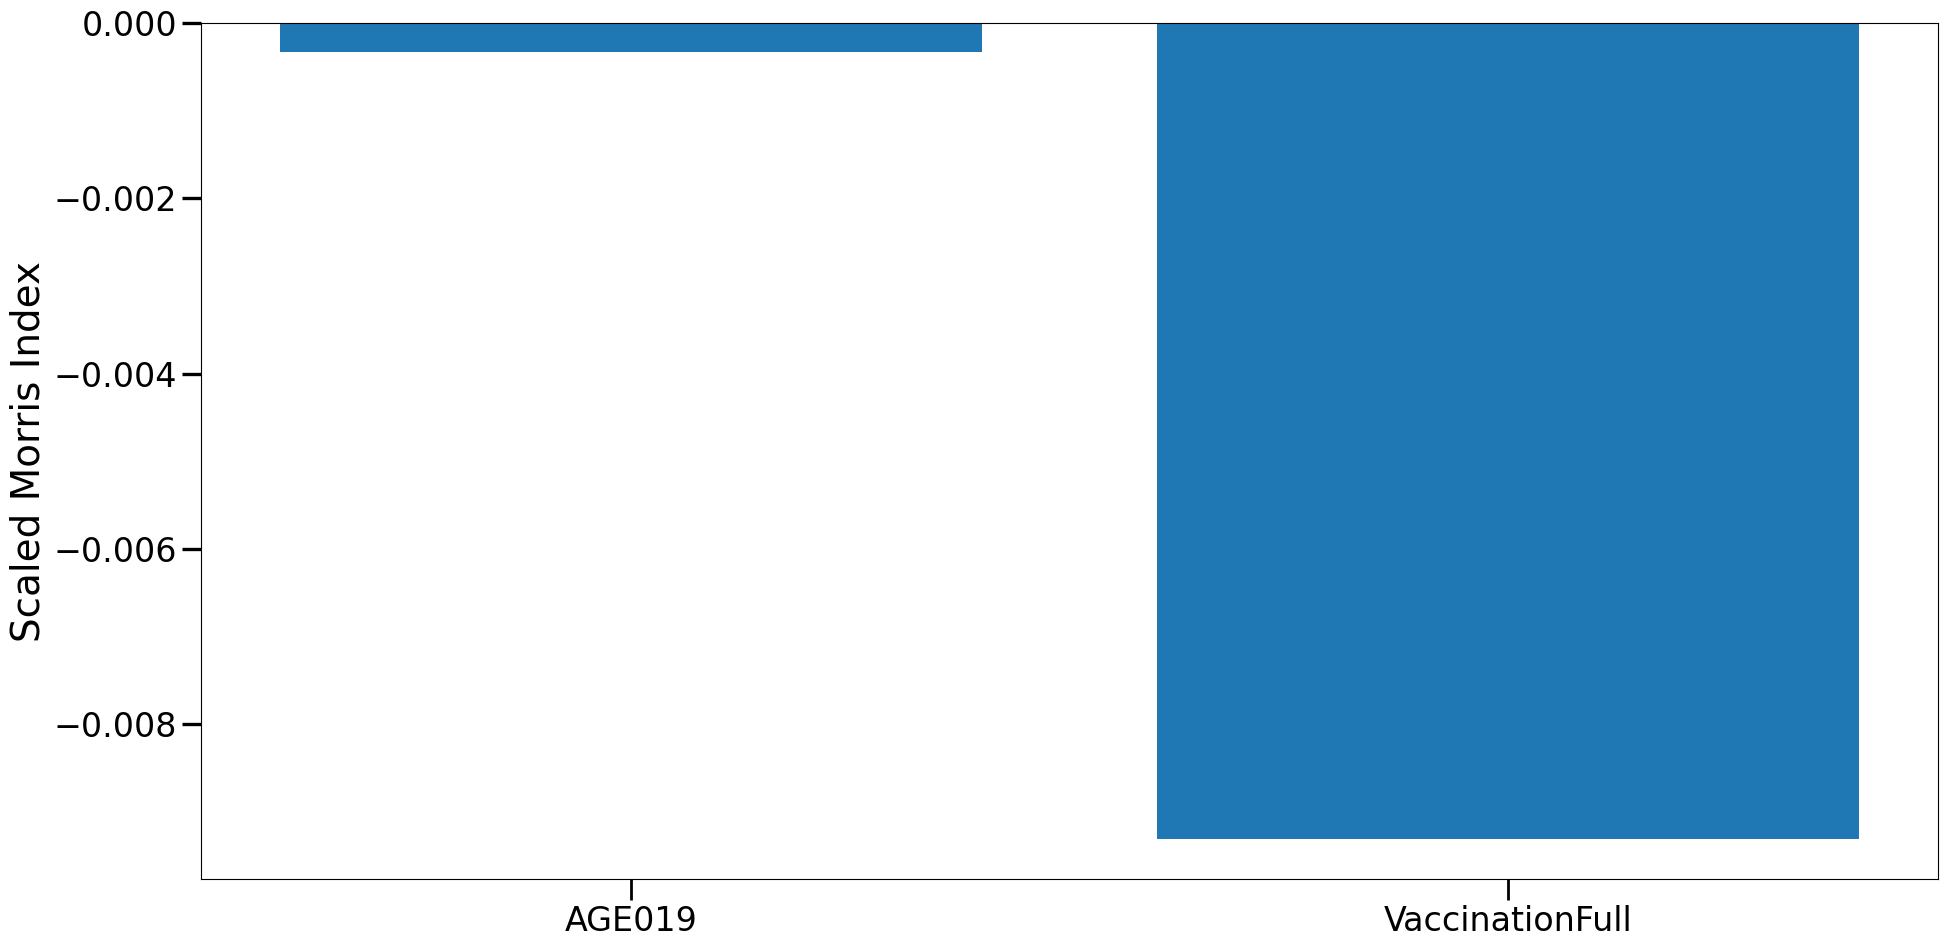

In [26]:
for delta in delta_values:
    print(delta)
    fig = plt.figure(figsize = (20, 10))
    plt.bar(features, result_df[result_df['Delta']==delta]['Morris_sensitivity'])
    
    plt.ylabel("Scaled Morris Index")
    plt.tight_layout()
    plt.savefig(os.path.join(args.figPath, f'delta_{delta}.jpg'), dpi=200)
    plt.show()
    # break

# End

In [ ]:
print(f'Ended at {datetime.now()}. Elapsed time {datetime.now() - start}')